# 平均場理論
ハバード模型を平均場近似したハミルトニアン
$$
\begin{align*}
 \mathcal{H}_{\mathrm{MF}}
 &= \frac{1}{2} \sum_{\boldsymbol{k}}
 \begin{bmatrix}
  \boldsymbol{c}_{\boldsymbol{k}}^\dagger & \boldsymbol{c}_{\boldsymbol{k}+\boldsymbol{Q}}^\dagger
 \end{bmatrix}
 \hat{H}_{\mathrm{MF}}(\boldsymbol{k})
 \begin{bmatrix}
  \boldsymbol{c}_{\boldsymbol{k}} \\
  \boldsymbol{c}_{\boldsymbol{k}+\boldsymbol{Q}}
 \end{bmatrix} \\
 \hat{H}_{\mathrm{MF}}(\boldsymbol{k}) &:=
 \begin{bmatrix}
  \hat{H}_0(\boldsymbol{k}) & - 2Um \hat{\mathcal{O}}_{\mathcal{M}} \\
  - 2Um \hat{\mathcal{O}}_{\mathcal{M}}^\dagger & \hat{H}_0(\boldsymbol{k}+\boldsymbol{Q})
 \end{bmatrix}
\end{align*}
$$
を考えます。
ただし、$\hat{H}_0(\boldsymbol{k})$は一体ハミルトニアンを表し、$\hat{\mathcal{O}}_{\mathcal{M}}$は目的の磁気秩序を表す行列とします。
この平均場ハミルトニアン$\hat{H}_{\mathrm{MF}}(\boldsymbol{k})$を対角化するユニタリ行列を
$$
\begin{equation*}
 \hat{V}(\boldsymbol{k}) =
 \begin{bmatrix}
  \hat{v}_1(\boldsymbol{k}) \\
  \hat{v}_2(\boldsymbol{k})
 \end{bmatrix}
\end{equation*}
$$
とし、対角化によって得られるエネルギー分散を$E(\boldsymbol{k})_\alpha \ (\alpha = 1, \dots, 4d)$とします。
これらを用い、電子数密度と1サイトあたりの磁気秩序変数に関する方程式
$$
\begin{align*}
 n_{\mathrm{e}} &= \frac{1}{2Nd} \sum_{\boldsymbol{k}} \sum_{\alpha=1}^{4d} f[E(\boldsymbol{k})_\alpha] \\
 m &= \frac{1}{Nd} \sum_{\boldsymbol{k}} \sum_{\alpha=1}^{4d} f[E(\boldsymbol{k})_\alpha] \Re\left[
 \hat{v}_1(\boldsymbol{k})^\dagger \hat{\mathcal{O}}_\mathcal{M} \hat{v}_2(\boldsymbol{k})
 \right]_{\alpha, \alpha}
\end{align*}
$$
を解くプログラムを作成します。

## 準備
まずは必要なパッケージを読み込みます。
もしパッケージがインストールされていない場合は、
```julia
using Pkg
Pkg.add("Foo") 
```
とすることでFoo.jlをインストールすることができます。
また、$2 \times 2$単位行列$\hat{\sigma}_0$およびパウリ行列$\hat{\sigma}_1, \hat{\sigma}_2, \hat{\sigma}_3$を用意しておきます。

In [1]:
using LinearAlgebra
using Optim
using Plots
using LaTeXStrings

const σ0 = ComplexF64[1 0; 0 1]
const σ1 = ComplexF64[0 1; 1 0]
const σ2 = ComplexF64[0 -1im; 1im 0]
const σ3 = ComplexF64[1 0; 0 -1]
;

# 計算に必要な関数の定義
次に、一体ハミルトニアン$\hat{H}_0(\boldsymbol{k})$を定義します(define_H0)。
今回は最近接の遷移積分のみ含んだ正方格子と、副格子に依存する次近接遷移積分まで含んだ異方的正方格子の2つを考えています。
定義に必要なパラメータは構造体(struct)を使ってひとまとめにしておくと便利です。

In [2]:
mutable struct Parameters
    system::String
    nsub::Int
    ndeg::Int
    t1::Float64
    t2::Float64
    U::Float64
    T::Float64
    nk1::Int
    nk2::Int
    nk3::Int
end

"一体ハミルトニアンを定義"
function define_H0(k::Vector{Float64}, p::Parameters)
    hamil = Matrix{ComplexF64}(undef, p.ndeg, p.ndeg)

    # systemの値に応じてハミルトニアンを定義(スピン軌道相互作用は無視し、遷移積分のみ)
    if p.system == "square"
        hamil .= - 2p.t1 * (cos(k[1]) + cos(k[2])) .* σ0
    elseif p.system == "modified_square"
        hamil .= (
            - 4p.t1 * cos(k[1]/2) * cos(k[2]/2) .* kron(σ1, σ0)
            .- 2p.t2 * cos(k[1]) * cos(k[2]) .* kron(σ0, σ0)
            .+ 2p.t2 * sin(k[1]) * sin(k[2]) .* kron(σ3, σ0)
        )

        ### ブリルアンゾーンの周期性を保つためのユニタリ変換
        # u::Matrix{ComplexF64} = kron(diagm([exp(0.5im*k[2]), exp(0.5im*k[1])]), σ0)
        # hamil = u' * hamil * u
    end

    hamil
end
;

一体ハミルトニアンと同様に、平均場ハミルトニアン$\hat{H}_{\mathrm{MF}}(\boldsymbol{k})$を定義します(define_H_MF)。
$\boldsymbol{Q} = \boldsymbol{0}$の強的秩序の場合にハミルトニアンの自由度を2倍にするのは無駄なので本当は場合分けした方が良いですが、簡単のため今回は場合分けなしで扱うことにします。

In [3]:
mutable struct MeanField
    n_fill::Float64
    μ::Float64
    m::Float64
    Q::Vector{Float64}
    Om::Matrix{ComplexF64}
    eps::Float64
    it_max::Int
end

"平均場ハミルトニアンを定義"
function define_H_MF(k::Vector{Float64}, p::Parameters, mf::MeanField)
    hamil_MF = Matrix{ComplexF64}(undef, 2*p.ndeg, 2*p.ndeg)

    # ハミルトニアンを定義
    ## 対角部分
    hamil_MF[1:p.ndeg, 1:p.ndeg] .= define_H0(k, p)
    hamil_MF[p.ndeg+1:end, p.ndeg+1:end] .= define_H0(k .+ mf.Q, p)

    ## 非対角部分(ハバード模型の平均場)
    hamil_MF[1:p.ndeg, p.ndeg+1:end] .= -2*p.U*mf.m .* mf.Om
    hamil_MF[p.ndeg+1:end, 1:p.ndeg] .= -2*p.U*mf.m .* mf.Om'

    hamil_MF
end
;

フェルミ分布関数
$$
\begin{equation*}
 f(E) = \frac{1}{\mathrm{e}^{E/T} + 1}
 = \frac{1}{2} \left(1 - \tanh\frac{E}{2T}\right)
\end{equation*}
$$
を定義します(fermi)。
なお、低温では指数関数の寄与が発散的になってしまうので、数値的には最右辺の定義を用いた方が安定します。
次に、ハミルトニアンを対角化して得られる固有値および固有ベクトルを用い、電子数密度および磁気秩序変数を計算する関数を定義します(calculate_electron_number, calculate_magnetic_order)。
また、与えられた電子数密度に対応する化学ポテンシャルを求めるための関数を定義しておきます(set_μ!)。
Optim.jlパッケージのminimizerを使うと、関数$f(x)$を最小化する$x$の値を得ることができるので、これを利用してBrent法で化学ポテンシャルを求めています。
(言語によっては対応するパッケージがないかもしれませんが、電子数密度は化学ポテンシャルの単調関数なので、二分法などを用いて解を求めるコードを自前で書くのも比較的容易にできるはずです。)

In [4]:
"フェルミ分布関数"
function fermi(E::Real, T::Real)
    # expを使うよりtanhを使う方が安定する
    0.5 * (1 - tanh(E / (2T)))
end

"電子数密度の計算"
function calculate_electron_number(func_H::Function, p::Parameters, μ::Float64)
    ne::Float64 = 0.0
    for ik3 in 1:p.nk3, ik2 in 1:p.nk2, ik1 in 1:p.nk1
        ### 波数ベクトルの定義
        k1 = (2π*(ik1-1)) / p.nk1
        k2 = (2π*(ik2-1)) / p.nk2
        k3 = (2π*(ik3-1)) / p.nk3

        ### ハミルトニアンの対角化
        hamil::Matrix{ComplexF64} = func_H([k1, k2, k3])
        evals = real.(eigvals(hamil))

        ### 電子数の計算
        for eval in evals
            ne += fermi(eval - μ, p.T)
        end
    end

    # サイト数あたりの電子数
    ## 平均場ハミルトニアンか否かで見た目の自由度が変わるので、行列のサイズを取得する
    nsub::Int = size(func_H([0.0, 0.0, 0.0]), 1) ÷ 2
    ne / (p.nk1 * p.nk2 * p.nk3 * nsub)
end

"与えられた電子数密度(n_fill)と対応する化学ポテンシャルを求める"
function set_μ!(func_H::Function, p::Parameters, mf::MeanField)
    # Brent法に基づいて化学ポテンシャルを求める
    res = optimize(
        μ -> (calculate_electron_number(func_H, p, μ) - mf.n_fill)^2,
        -5, 5, rel_tol=1e-6, Brent()
    )
    mf.μ = Optim.minimizer(res)[1]
end

"平均場近似に基づく磁気秩序変数の計算"
function calculate_magnetic_order(p::Parameters, mf::MeanField)
    m::Float64 = 0.0
    for ik3 in 1:p.nk3, ik2 in 1:p.nk2, ik1 in 1:p.nk1
        ### 波数ベクトルの定義
        k1 = (2π*(ik1-1)) / p.nk1
        k2 = (2π*(ik2-1)) / p.nk2
        k3 = (2π*(ik3-1)) / p.nk3

        ### 平均場ハミルトニアンの対角化
        hamil = define_H_MF([k1, k2, k3], p, mf)
        evals, evecs = eigen(hamil)

        ### 磁気秩序変数の計算
        for ie in eachindex(evals)
            m += fermi(real(evals[ie]) - mf.μ, p.T) * (
                sum(
                    real(conj(evecs[iζ1, ie]) * mf.Om[iζ1, iζ2] * evecs[iζ2+p.ndeg, ie])
                    for iζ1 in 1:p.ndeg, iζ2 in 1:p.ndeg
                )
            )
        end
    end

    # サイト数あたりの磁気秩序変数
    m / (p.nk1 * p.nk2 * p.nk3 * p.nsub)
end
;

平均場方程式を解く関数を作成します(solve_MF_equation!)。
ここでは最も簡単な逐次代入法を採用して磁気秩序変数mを決定しています(より速いアルゴリズムも存在するはずです)。
mが変化すると与えられた電子数密度に対応する化学ポテンシャルの値も変わるので、イテレーションの中で毎回計算し直すようにしています。

In [5]:
"平均場方程式を解いて化学ポテンシャルと磁気秩序変数を求める"
function solve_MF_equation!(p::Parameters, mf::MeanField)
    # パラメータの初期値セット
    ## 有限の秩序変数を「種」として入れておく
    mf.m = 0.1; m_old::Float64 = 0.0
    set_μ!(k -> define_H_MF(k, p, mf), p, mf)

    # 平均場解を求めるためのループ
    count::Int64 = 1
    rel_err::Float64 = abs(mf.m - m_old) / abs(mf.m)
    while rel_err > mf.eps && abs(mf.m) > 1e-8
        ### 規定の回数(it_max)を越えたら、収束していないとみなしてループを抜ける
        if count >= mf.it_max
            println("rel_err=$rel_err after $(mf.it_max) loops -> self-consistent calculation stop!")
            println("$count: μ = $(mf.μ), m = $(mf.m); not converge")
            break
        end

        ### 逐次代入法で次の秩序変数の値を決める
        m_old = mf.m
        mf.m = calculate_magnetic_order(p, mf)
        rel_err = abs(mf.m - m_old) / abs(mf.m)

        ### 平均場の値によって化学ポテンシャルが変わるので、毎回計算し直す
        set_μ!(k -> define_H_MF(k, p, mf), p, mf)

        ### 適宜経過を出力する
        count % 101 == 0 && println("$count: μ = $(mf.μ), m = $(mf.m)")
        count += 1
    end

    # 収束解の出力
    count < mf.it_max && println("$count: μ = $(mf.μ), m = $(mf.m); converge")

    mf.μ, abs(mf.m)
end
;

平均場ハミルトニアンに基づいてエネルギーバンド分散を描く関数を定義しておきます(plot_energy_band)。
主に交替磁性の可視化を分かりやすくするため、スピンのアップ/ダウンに応じて色分けするようにしています。

In [6]:
function construct_mesh(start::AbstractVector, goal::AbstractVector, nmesh::Int; endpoint=false)
    dr = (goal .- start) ./ nmesh
    [start .+ (n-1) .* dr for n in 1:ifelse(endpoint, nmesh+1, nmesh)]
end

"ハミルトニアンを対角化し、高対称パスに沿ってエネルギーバンド分散を描く"
function plot_energy_band(p::Parameters, mf::MeanField)
    # 高対称点の指定
    kΓ::Vector{Float64} = [0.0, 0.0, 0.0]
    kX::Vector{Float64} = [π, 0.0, 0.0]
    kY::Vector{Float64} = [0.0, π, 0.0]
    kM1::Vector{Float64} = [π, π, 0.0]
    kM2::Vector{Float64} = [-π, π, 0.0]

    # パスの指定
    ## Γ -> Y -> M2 -> Γ -> M1 -> X -> Γ
    kpath::Vector{Vector{Vector{Float64}}} = [[kΓ, kY, kM2, kΓ, kM1, kX, kΓ]]
    kpath_str::Vector{String} = ["Γ", "Y", "M", "Γ", "M", "X", "Γ"]

    # 波数メッシュの作成
    nk::Int = 128                    # 2点間のメッシュ数
    ks::Vector{Vector{Float64}} = [] # パスに沿った各k点
    for ikb in eachindex(kpath)
        kblock = kpath[ikb]
        for ikp in 1:(length(kblock)-1)
            endpoint = Bool(ikb == length(kpath) && ikp == length(kblock)-1)
            push!(ks, construct_mesh(kblock[ikp], kblock[ikp+1], nk; endpoint=endpoint)...)
        end
    end

    # パス上のエネルギー分散とアップスピンの重みを計算
    nband = ifelse(mf.Q == [0.0, 0.0, 0.0], p.ndeg, 2*p.ndeg)
    evals::Matrix{Float64} = zeros(Float64, length(ks), nband)
    weights_up::Matrix{Float64} = zeros(Float64, length(ks), nband)
    for ik in eachindex(ks)
        ### ハミルトニアンの定義
        hamil = (
            mf.Q == [0.0, 0.0, 0.0] ?
            define_H0(ks[ik], p) .- 2*p.U*mf.m .* mf.Om :
            define_H_MF(ks[ik], p, mf)
        )

        ### ハミルトニアンの対角化
        e, u = eigen(hamil)
        evals[ik, :] .= real.(e)
        for ie in eachindex(e)
            ##### アップスピン成分の重みを計算
            weights_up[ik, ie] = norm(u[1:2:nband, ie])^2
        end
    end
    ## プロットが綺麗に見えるようにソートしておく
    s = sortperm(weights_up, dims=2, rev=true)
    evals = evals[s]
    weights_up = weights_up[s]

    # プロットのための準備
    ## パスを一直線にしたときの長さを計算しておく
    ks_plt = zeros(Float64, length(ks))
    kticks = [0.0]
    for ik in 1:(length(ks)-1)
        ks_plt[ik+1] = ks_plt[ik] + norm((ks[ik+1] .- ks[ik]))

        ### 高対称点でのパスの長さを用意(横軸ラベルで使用)
        ik % nk == 0 && push!(kticks, ks_plt[ik+1])
    end

    # エネルギー分散のプロット
    plt = scatter(
        ks_plt, evals, zcolor=weights_up, legend=false, colorbar=true,
        color=:bwr, markersize=((weights_up .+ 4)./3), markerstrokewidth = 0,
        xticks=(kticks, kpath_str), ylabel=L"E",
        guidefontsize=24, tickfontsize=18,
        margin=Plots.Measures.Length(:mm, 2)
    )

    # 化学ポテンシャルのプロット
    plot!(plt, ks_plt[[1, end]], [mf.μ, mf.μ], lc=:green, lw=1, linestyle=:dash)

    plt
end
;

## 実際の計算例
### 正方格子ハバード模型における反強磁性秩序
ここまで定義した関数を用いて具体的に計算を行っていきます。
まずは正方格子ハバード模型の反強磁性秩序について、温度を変化させたときの平均場解を求めます。
実行には数分かかるので注意してください。
一般に転移温度付近は収束性が悪く、収束に必要なループの回数が増えます。
また、ここではデモンストレーションなのでグローバルスコープでプログラムを実行していますが、実際の計算でグローバル変数を用いるのは避けた方が良いです。

In [7]:
# 初期パラメータを設定
## ここから ##
system = "square"
nsub = 1 # スピン以外(副格子)の内部自由度
ndeg = 2 # スピンも含めた全内部自由度
t1 = 1.0
t2 = 0.0
U = 2.0
T = 0.01
nk1, nk2, nk3 = 64, 64, 1
p = Parameters(system, nsub, ndeg, t1, t2, U, T, nk1, nk2, nk3)

n_fill = 1.0
μ = 0.0
m = 0.0
Q = [π, π, 0.0] # 反強磁性
Om = σ3 ./ 2 # 磁気多極子演算子(z方向のモーメント)
eps = 1e-4
it_max = 10000
mf = MeanField(n_fill, μ, m, Q, Om, eps, it_max)
## ここまで ##

# 一体ハミルトニアンの化学ポテンシャルを計算する
mf.m = 0.0
set_μ!(k -> define_H0(k, p), p, mf)
println("Chemical potential without mean field μ0 = $(mf.μ)")
println()

# 調べたいパラメータ領域を設定する
Ts = 0.01:0.01:0.25 # 温度

# 各パラメータで平均場解を求める
isdir("data") || mkdir("data")
μs = Array{Float64}(undef, length(Ts))
ms = Array{Float64}(undef, length(Ts))
for iT in eachindex(Ts)
    println("## T = $(Ts[iT])")
    p.T = Ts[iT]

    @time solve_MF_equation!(p, mf)
    println()

    ### データを出力
    open("data/$(p.system)_MF_AFM_order.txt", "a") do log
        println(log, "$(p.T) $(mf.μ) $(mf.m)")
    end

    ### 自己無撞着に決めた秩序変数を配列に格納
    μs[iT] = mf.μ
    ms[iT] = mf.m
end

Chemical potential without mean field μ0 = 2.3831943038390093e-16

## T = 0.01
16: μ = -6.217248937900877e-15, m = 0.18802530702670886; converge
  4.861861 seconds (56.31 M allocations: 14.048 GiB, 11.33% gc time, 10.95% compilation time)

## T = 0.02
16: μ = -5.10702591327572e-15, m = 0.18802530505828052; converge
  4.848903 seconds (60.57 M allocations: 15.584 GiB, 12.41% gc time)

## T = 0.03
16: μ = -3.352873534367973e-14, m = 0.18802465925890904; converge
  4.442407 seconds (55.28 M allocations: 14.156 GiB, 13.08% gc time)

## T = 0.04
16: μ = 9.769962616701378e-15, m = 0.1880093717280672; converge
  5.016532 seconds (60.88 M allocations: 15.668 GiB, 13.45% gc time)

## T = 0.05
16: μ = 2.220446049250313e-14, m = 0.1879120122808387; converge
  4.923179 seconds (60.96 M allocations: 15.689 GiB, 12.57% gc time)

## T = 0.06
16: μ = -1.709743457922741e-14, m = 0.18759705947128136; converge
  4.124907 seconds (50.69 M allocations: 12.917 GiB, 12.46% gc time)

## T = 0.07
17: μ = -1.82

結果をプロットし、図をpng形式で保存します。

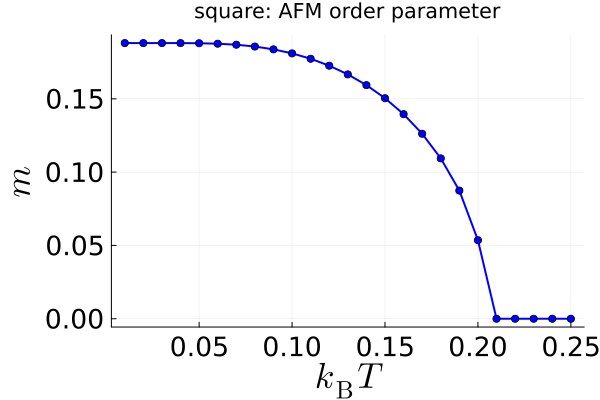

In [8]:
# 結果のプロットを行う
## 平均場で得られた秩序変数の温度依存性
plt = plot(
    Ts, ms, legend=false, lc=:blue, lw=2,
    markershape=:circle, markercolor=:blue, markersize=4,
    title="$(p.system): AFM order parameter",
    xlabel=L"k_{\mathrm{B}}T", ylabel=L"m",
    guidefontsize=24, tickfontsize=18,
    margin=Plots.Measures.Length(:mm, 2)
)
display(plt)

## 図をファイルに保存
isdir("images") || mkdir("images")
savefig(plt, "images/$(p.system)_MF_AFM_order.png")
;

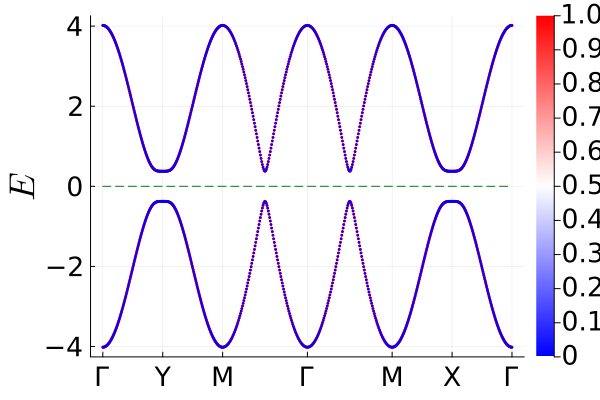

In [9]:
## 最低温の反強磁性秩序状態でのエネルギーバンド分散
mf.μ = μs[1]
mf.m = ms[1]
plt = plot_energy_band(p, mf)
display(plt)

## 図をファイルに保存
savefig(plt, "images/$(p.system)_MF_AFM_band.png")
;

### 異方的正方格子ハバード模型における反強磁性(交替磁性)秩序
次に、異方的正方格子模型で同様の計算を行います。
単位胞が広がっているので、QとOmの定義が変わっていることに注意してください。
副格子が1から2に増えた分、ハミルトニアンの次元が上がって実行時間が長くなります。

In [10]:
# 初期パラメータを設定
## ここから ##
system = "modified_square"
nsub = 2 # スピン以外(副格子)の内部自由度
ndeg = 4 # スピンも含めた全内部自由度
t1 = 1.0
t2 = 0.15
U = 2.0
T = 0.01
nk1, nk2, nk3 = 64, 64, 1
p = Parameters(system, nsub, ndeg, t1, t2, U, T, nk1, nk2, nk3)

n_fill = 1.0
μ = 0.0
m = 0.0
Q = [0.0, 0.0, 0.0] # 強的秩序
Om = kron(σ3, σ3) ./ 2 # 磁気多極子演算子(z方向のスタッガードモーメント)
eps = 1e-4
it_max = 10000
mf = MeanField(n_fill, μ, m, Q, Om, eps, it_max)
## ここまで ##

# 一体ハミルトニアンの化学ポテンシャルを計算する
mf.m = 0.0
set_μ!(k -> define_H0(k, p), p, mf)
println("Chemical potential without mean field μ0 = $(mf.μ)")
println()

# 調べたいパラメータ領域を設定する
Ts = 0.01:0.01:0.25 # 温度

# 各パラメータで平均場解を求める
μs = Array{Float64}(undef, length(Ts))
ms = Array{Float64}(undef, length(Ts))
for iT in eachindex(Ts)
    println("## T = $(Ts[iT])")
    p.T = Ts[iT]

    @time solve_MF_equation!(p, mf)
    println()

    ### データを出力
    open("data/$(p.system)_MF_AFM_order.txt", "a") do log
        println(log, "$(p.T) $(mf.μ) $(mf.m)")
    end

    ## 自己無撞着に決めた秩序変数を配列に格納
    μs[iT] = mf.μ
    ms[iT] = mf.m
end

Chemical potential without mean field μ0 = -0.08196121254492496

## T = 0.01
20: μ = -0.0051012975074998, m = 0.1822516993768065; converge
  8.934890 seconds (55.23 M allocations: 24.325 GiB, 5.59% gc time)

## T = 0.02
21: μ = -0.010862238158154763, m = 0.18166562219077043; converge
  9.227855 seconds (57.90 M allocations: 25.487 GiB, 5.31% gc time)

## T = 0.03
24: μ = -0.015854294456615, m = 0.17965912887121274; converge
  9.132660 seconds (58.86 M allocations: 25.372 GiB, 4.90% gc time)

## T = 0.04
27: μ = -0.020446138799986777, m = 0.17608102661962063; converge
  9.386245 seconds (60.23 M allocations: 25.466 GiB, 5.20% gc time)

## T = 0.05
30: μ = -0.024841344163263866, m = 0.1710441525697808; converge
  9.943537 seconds (64.46 M allocations: 27.021 GiB, 5.09% gc time)

## T = 0.06
34: μ = -0.029052158815266804, m = 0.1646789421366545; converge
 10.767184 seconds (70.04 M allocations: 29.061 GiB, 5.02% gc time)

## T = 0.07
38: μ = -0.03299940653932481, m = 0.1570200762637362; c

結果をプロットします。

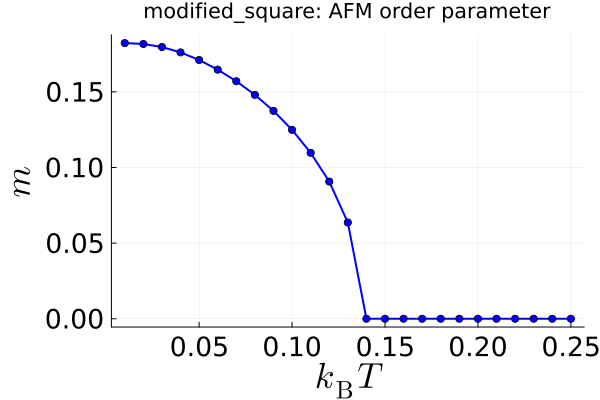

In [11]:
# 結果のプロットを行う
## 平均場で得られた秩序変数の温度依存性
plt = plot(
    Ts, ms, legend=false, lc=:blue, lw=2,
    markershape=:circle, markercolor=:blue, markersize=4,
    title="$(p.system): AFM order parameter",
    xlabel=L"k_{\mathrm{B}}T", ylabel=L"m",
    guidefontsize=24, tickfontsize=18,
    margin=Plots.Measures.Length(:mm, 2)
)
display(plt)

## 図をファイルに保存
isdir("images") || mkdir("images")
savefig(plt, "images/$(p.system)_MF_AFM_order.png")
;

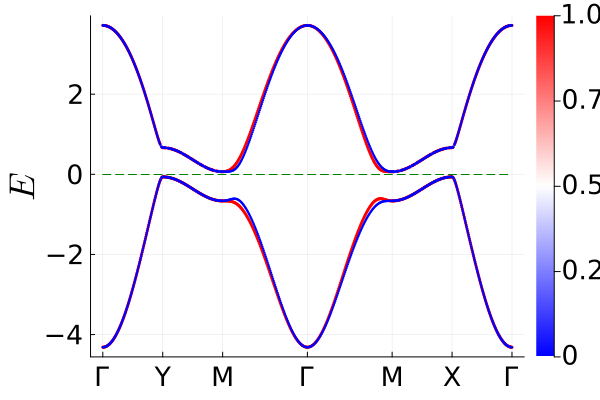

In [12]:
## 最低温の反強磁性秩序状態でのエネルギーバンド分散
mf.μ = μs[1]
mf.m = ms[1]
plt = plot_energy_band(p, mf)
display(plt)

## 図をファイルに保存
savefig(plt, "images/$(p.system)_MF_AFM_band.png")
;